In [ ]:
# -*- coding: utf-8 -*-
"""Toy Autoencoder

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1a6NinZgC8v4cDZtVX-rr65IVm7pxJLFd
"""

!pip install scanpy --quiet
!wget https://datasets.cellxgene.cziscience.com/4eb58518-23ce-43e8-89ca-9e9fa87c081d.h5ad -O tabula-sapiens-blood.h5ad

In [1]:
import torch
import numpy as np
import scanpy as sc

adata = sc.read_h5ad("tabula-sapiens-blood.h5ad")
X = torch.tensor(adata.raw.X.todense())

In [2]:
from torch import nn

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MessageSender(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128, latent_dim: int = 64):
        super(MessageSender, self).__init__()

        self.mean_encoder = Encoder(input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.logstd_encoder = Encoder(input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)

    def forward(self, x):
        # Is this necessary (comes from scVI basic doumentation).
        log_x = torch.log1p(x)
        mu = self.mean_encoder(log_x)
        logstd = self.logstd_encoder(log_x)
        return mu, logstd

    def sample(self, x):
        mu, logstd = self.forward(x)
        return Normal(mu, torch.exp(logstd) + 1e-4).rsample()

class Decoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128, latent_dim: int = 64):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MessageReceiver(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128, latent_dim: int = 64):
        super(MessageReceiver, self).__init__()

        self.alpha_decoder = Decoder(X.shape[1])
        self.beta_decoder = Decoder(X.shape[1])

    def forward(self, z):
        alpha = self.alpha_decoder(z)
        beta = self.beta_decoder(z)
        return F.softplus(alpha), beta

from torch.distributions import Normal, NegativeBinomial, Categorical, MixtureSameFamily, Independent

class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128, latent_dim: int = 64):
        super(VAE, self).__init__()
        # Message Passing
        self.message_sender = MessageSender(X.shape[1])
        self.message_receiver = MessageReceiver(X.shape[1])

        # Latent Representation Regularization
        self.n_gaussians = 10
        self.weights = nn.Parameter(torch.zeros(self.n_gaussians))
        self.means = nn.Parameter(torch.zeros(self.n_gaussians, 64))
        self.logstds = nn.Parameter(torch.zeros(self.n_gaussians, 64))

    def forward(self, x):
        z = self.message_sender.sample(x)
        alpha, beta = self.message_receiver(z)
        return z, alpha, beta

    def loss(self, x):
        z, alpha, beta = self.forward(x)
        beta += (x.sum(axis=1, keepdims=True) / x.sum(axis=1, keepdims=True).mean()).log()
        nb_nll = -NegativeBinomial(total_count=alpha, logits=beta).log_prob(X).sum(axis=1)
        mixing_distribution = Categorical(probs=torch.softmax(self.weights, dim=0))
        component_distribution = Independent(Normal(self.means, self.logstds.exp() + 1e-4), 1)
        gmm = MixtureSameFamily(mixing_distribution, component_distribution)
        latent_nll = -gmm.log_prob(z)

        return (latent_nll + nb_nll).mean()

from torch.distributions import Normal, NegativeBinomial, Categorical, MixtureSameFamily, Independent

class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128, latent_dim: int = 64):
        super(VAE, self).__init__()
        # Message Passing
        self.message_sender = MessageSender(X.shape[1])
        self.message_receiver = MessageReceiver(X.shape[1])

    def forward(self, x):
        z = self.message_sender.sample(x)
        alpha, beta = self.message_receiver(z)
        return z, alpha, beta

    def latent_representation(self, x):
        z, alpha, beta = self.forward(x)
        return z

    def loss(self, x):
        z, alpha, beta = self.forward(x)
        beta += (x.sum(axis=1, keepdims=True) / x.sum(axis=1, keepdims=True).mean()).log()
        nb_nll = -NegativeBinomial(total_count=alpha, logits=beta).log_prob(x).sum(axis=1)
        return (nb_nll).mean()

In [3]:
vae = VAE(X.shape[1])

discriminator = nn.Sequential(
    nn.Linear(64, 64 // 2),
    nn.LeakyReLU(0.2),
    nn.Linear(64 // 2, 64 // 4),
    nn.LeakyReLU(0.2),
    nn.Linear(64 // 4, 1),
    nn.Sigmoid()
)

# Improved Routine
This should be more robust in determining valid logstds for sampling, as it will now discriminate between unseen data samples and seen data samples. Ideally, this should mean the distribution it is estimating better tracts with the true uncertainty. 

In [4]:
import wandb
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

# Assuming 'X' is your full dataset tensor
dataset = TensorDataset(X)

# ===== Split the dataset =====
n_total = len(dataset)
n_recon = n_total // 2
n_nce = n_total - n_recon  # handle odd case

dataset_recon, dataset_nce = random_split(dataset, [n_recon, n_nce])

dataloader_recon = DataLoader(dataset_recon, batch_size=512, shuffle=True)
dataloader_nce = DataLoader(dataset_nce, batch_size=512, shuffle=True)

# ===== Optimizers =====
optimizer_generative = torch.optim.Adam(vae.parameters(), lr=1e-4)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

# ===== Initialize wandb =====
wandb.init(project="nce-vae", entity="jhaberbe", name="kanna-kanna-kanna-kanna-kanna-chameleon")

for epoch in tqdm(range(1000)):
    recon_iter = iter(dataloader_recon)
    nce_iter = iter(dataloader_nce)

    while True:
        try:
            batch_recon = next(recon_iter)[0]
            batch_nce = next(nce_iter)[0]
        except StopIteration:
            # If either iterator runs out of data, end epoch
            break

        # ==================== Train Discriminator on Set B ====================
        discriminator.train()
        optimizer_discriminator.zero_grad()

        with torch.no_grad():
            z_true, _ = vae.message_sender.forward(batch_nce)
            z_sampled = vae.message_sender.sample(batch_nce)

        pred_true = discriminator(z_true)
        pred_sampled = discriminator(z_sampled)

        bce_loss_true = F.binary_cross_entropy(pred_true, torch.ones_like(pred_true))
        bce_loss_sampled = F.binary_cross_entropy(pred_sampled, torch.zeros_like(pred_sampled))
        discriminator_loss = bce_loss_true + bce_loss_sampled

        discriminator_loss.backward()
        optimizer_discriminator.step()

        # ==================== Train VAE on Set A ====================
        vae.train()
        optimizer_generative.zero_grad()

        # Reconstruction Loss
        reconstruction_loss = vae.loss(batch_recon)

        # Fresh NCE loss (on Set B latents)
        z_true, _ = vae.message_sender.forward(batch_nce)
        z_sampled = vae.message_sender.sample(batch_nce)

        pred_true = discriminator(z_true)
        pred_sampled = discriminator(z_sampled)

        nce_loss = -(torch.log(pred_true + 1e-8).mean() + torch.log(1 - pred_sampled + 1e-8).mean())

        vae_loss = reconstruction_loss + nce_loss

        vae_loss.backward()
        optimizer_generative.step()

        # ==================== Logging ====================
        wandb.log({
            'vae_loss': vae_loss.item(),
            'reconstruction_loss': reconstruction_loss.item(),
            'nce_loss': nce_loss.item(),
            'discriminator_loss': discriminator_loss.item(),
        })


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jhaberbe (kibr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 3/1000 [49:47<275:47:41, 995.85s/it] 


KeyboardInterrupt: 

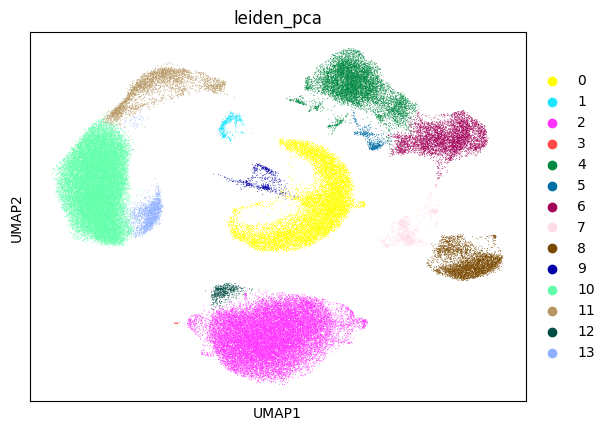

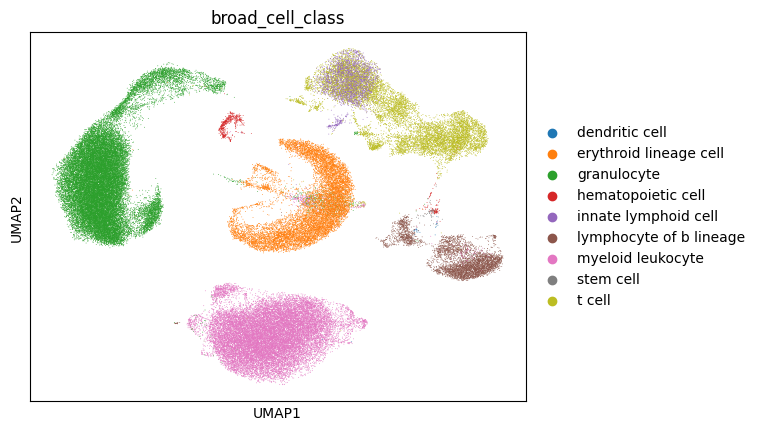

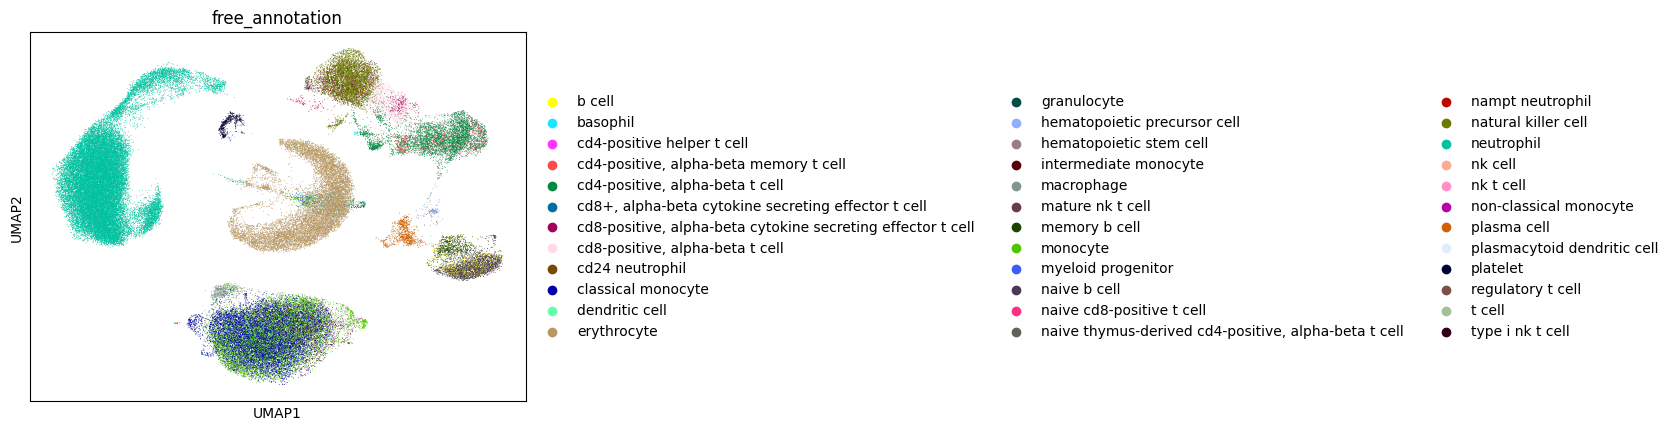

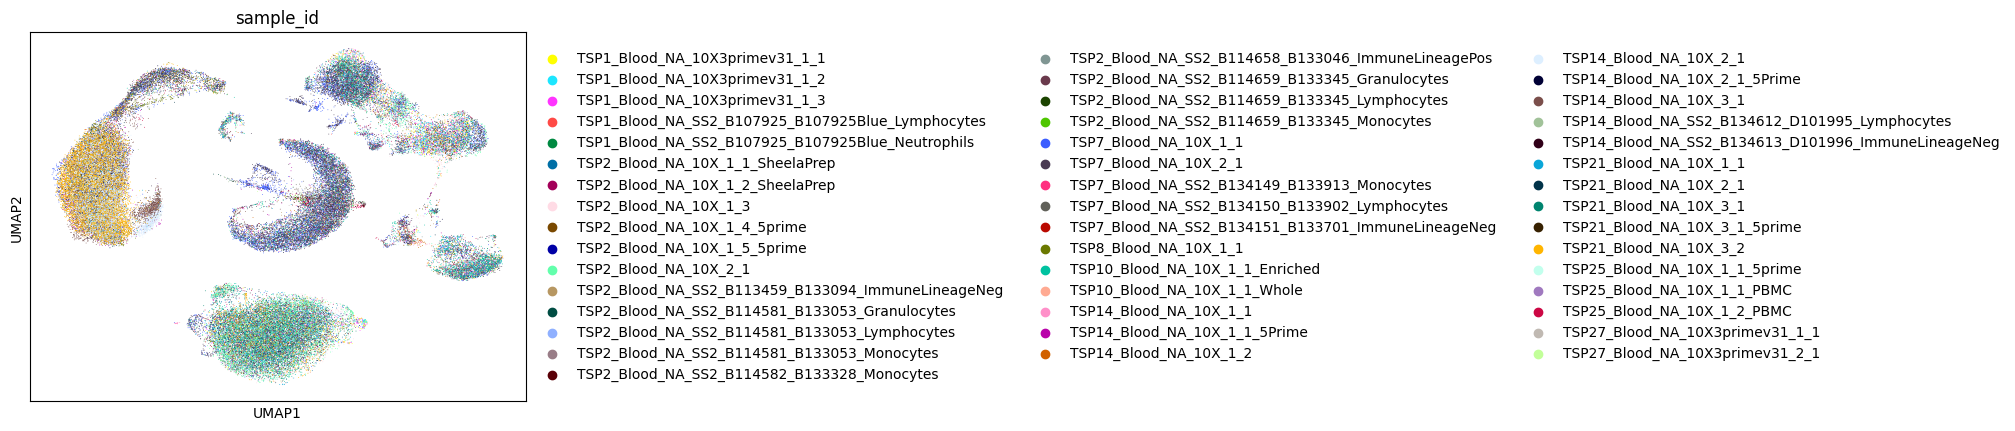

In [11]:
# sc.pp.highly_variable_genes(adata)
# sc.pp.pca(adata)
# sc.external.pp.harmony_integrate(adata, key="sample_id")

sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = .3, flavor="igraph", n_iterations=2, key_added="leiden_pca")

sc.pl.umap(adata, color="leiden_pca")
sc.pl.umap(adata, color="broad_cell_class")
sc.pl.umap(adata, color="free_annotation")
sc.pl.umap(adata, color="sample_id")

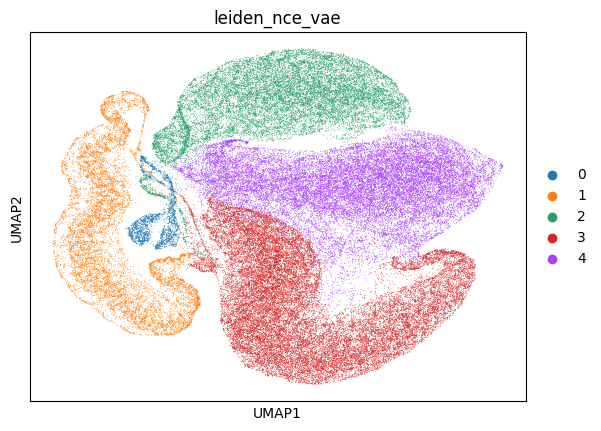

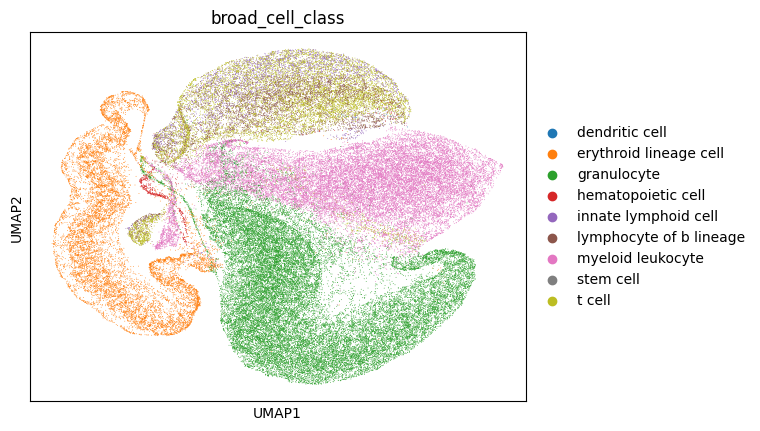

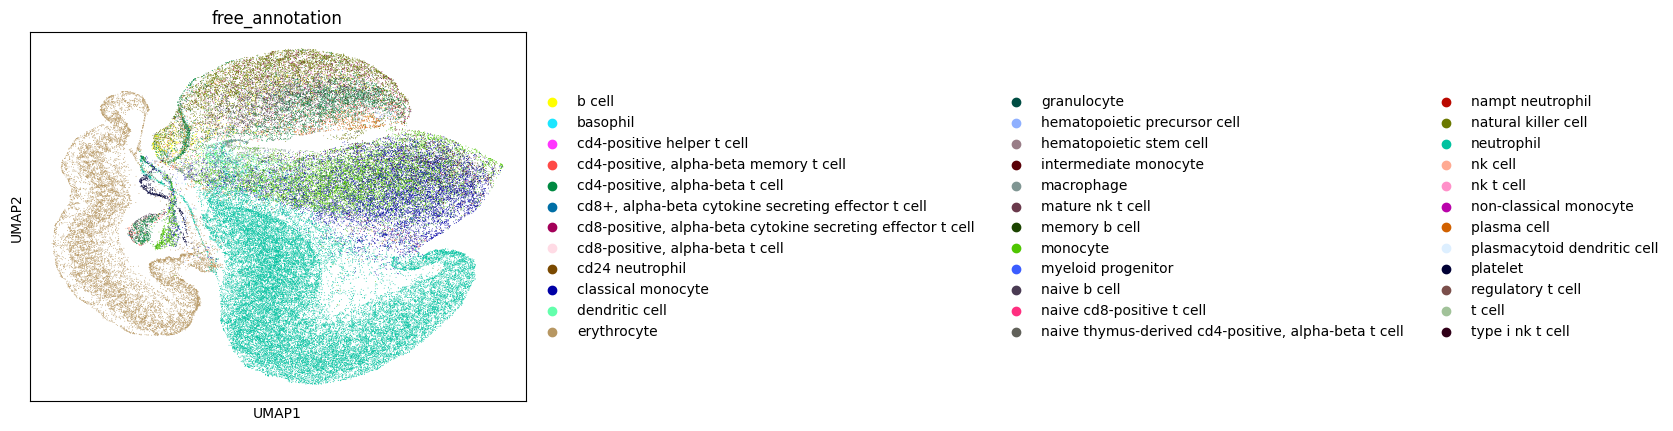

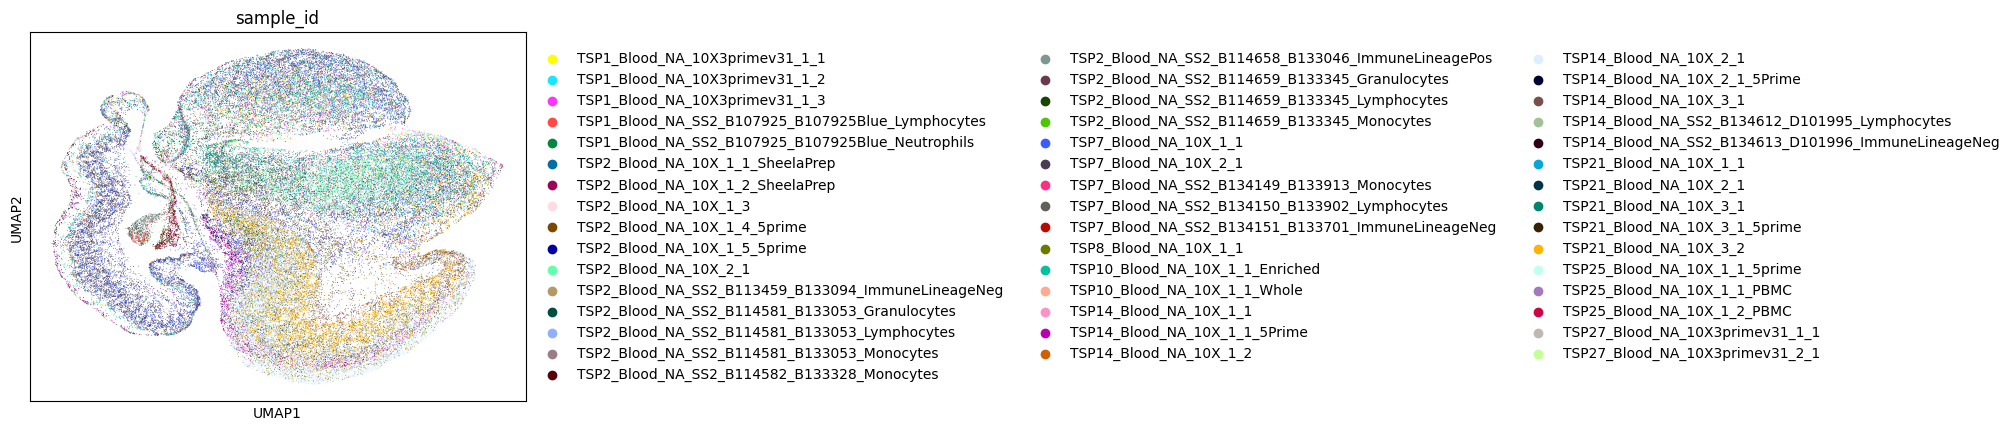

In [21]:
# adata.obsm["X_scVI"]  = vae.message_sender.mean_encoder(torch.log1p(X)).detach().numpy()
# sc.pp.neighbors(adata, use_rep="X_scVI")
# sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = .02, flavor="igraph", n_iterations=2, key_added="leiden_nce_vae")

sc.pl.umap(adata, color="leiden_nce_vae")
sc.pl.umap(adata, color="broad_cell_class")
sc.pl.umap(adata, color="free_annotation")
sc.pl.umap(adata, color="sample_id")

/tmp/ipykernel_17902/3902323404.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  adata.obs.pivot_table(index="broad_cell_class", columns="leiden_nce_vae", aggfunc="size"),


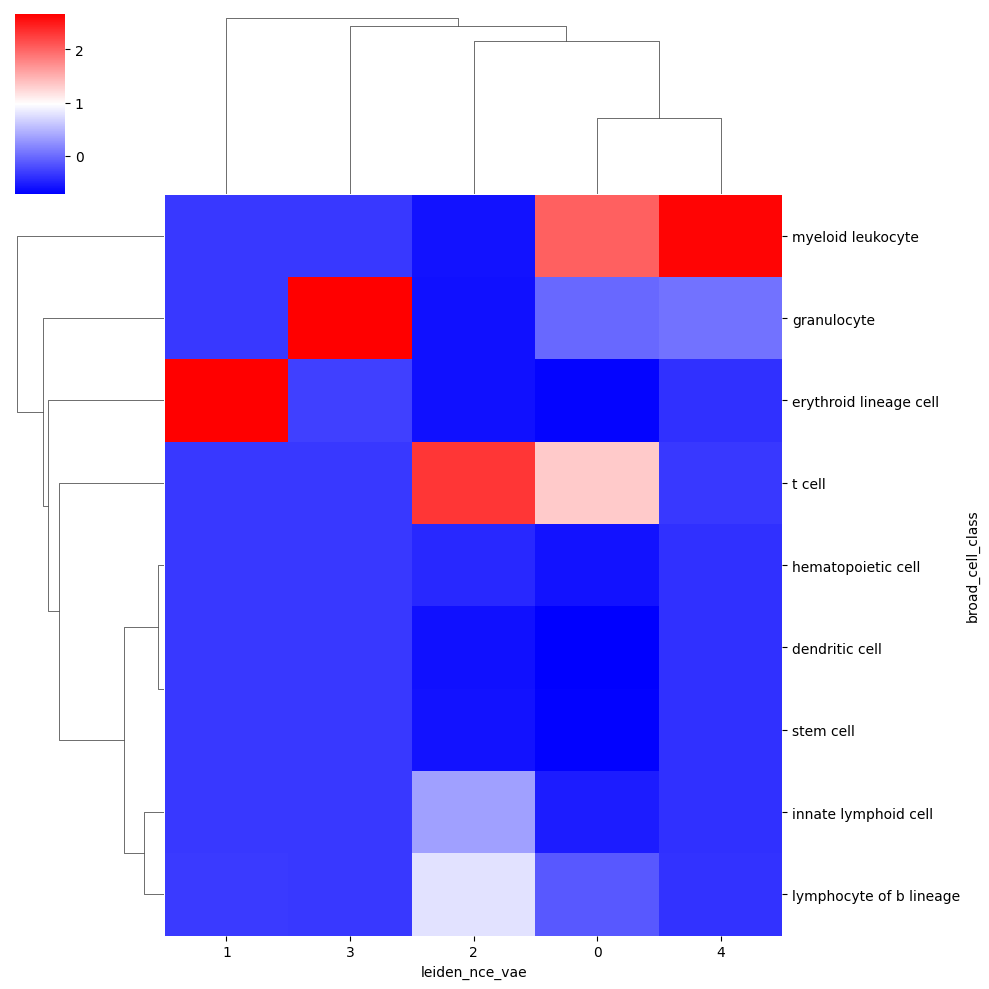

In [24]:
import seaborn as sns
sns.clustermap(
    adata.obs.pivot_table(index="broad_cell_class", columns="leiden_nce_vae", aggfunc="size"),
    z_score=1, 
    cmap="bwr"
)

/tmp/ipykernel_17902/580106345.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  adata.obs.pivot_table(index="broad_cell_class", columns="leiden_pca", aggfunc="size"),


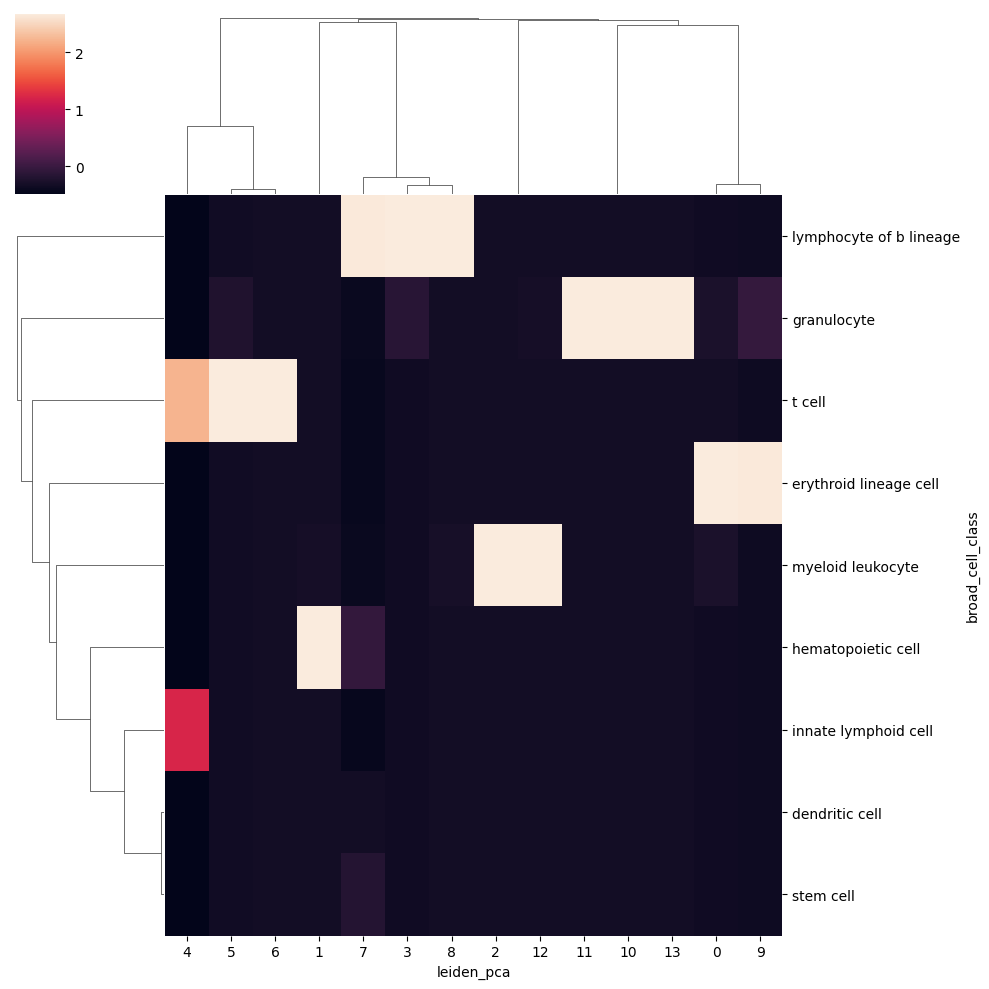

In [25]:
sns.clustermap(
    adata.obs.pivot_table(index="broad_cell_class", columns="leiden_pca", aggfunc="size"),
    z_score=1
)